In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
import datetime as dt
from scipy.interpolate import interp1d
 
df = pd.read_json('../data/database-10-12.json')

target = []

#### Ändere das Feature `date` zu einem einheitlichen Datum

In [9]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [10]:
df = df.loc[(df['date'] >= "2022-07-16") & (df['date'] <= "2022-10-27")]

#### Füge ein neues Feature hinzu: Stichwort

In [11]:
keywords = json.loads(open("keywords/keywords.json", "r").read())

target = keywords

df['tags_full'] = ['; '.join(tags) for tags in df.tags.to_list()]

for keyword in keywords:
    df.loc[(df.title.str.contains(keyword) | df.content.str.contains(keyword) | df.tags_full.str.contains(keyword)), 'keyword'] = keyword

#### Füge vier neue Features hinzu: Tag, Woche, Monat, Jahr

In [12]:
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

#### Filter die Artikel nach: Sind dem Themengebiet „Covid-19-Pandemie“ zugeordnet

## 1. Gruppiere Artikel nach: Tag (eindeutig)

In [13]:
df_all_day = None

for keyword in keywords:
    # Betrachte nur die Artikel des aktuellen Themengebiets
    df_keyword = df.loc[df.keyword == keyword]
    # Gruppiere die Artikel nach Woche (eindeutig) und aggregiere die Anzahl der Artikel pro Woche
    df_daily_keyword = df_keyword.groupby(["day", "month", "year"]).size().reset_index(name=keyword)
    
    # Füge ein neues Feature hinzu: Datum
    df_daily_keyword['date'] = pd.to_datetime(df_daily_keyword[["year", "month", "day"]])

    # Lösche zwei Features: Woche, Jahr
    df_daily_keyword.drop(['day', 'month', 'year'], axis=1, inplace=True)

    # Falls der df der Gesamtdaten bereits Daten von vorherigen Themengebieten enthält, merge die Daten des aktuellen Themengebiets
    if (isinstance(df_all_day, pd.DataFrame)):
        df_all_day = pd.merge(df_all_day, df_daily_keyword, how='outer', on="date")
    # Initialisiere den df der Gesamtdaten mit den Daten des aktuellen Themengebiets
    else:
        df_all_day = df_daily_keyword

# Fülle die leeren Felder mit der Anzahl 0
df_all_day = df_all_day.fillna(0)

#### Erstelle das Diagramm

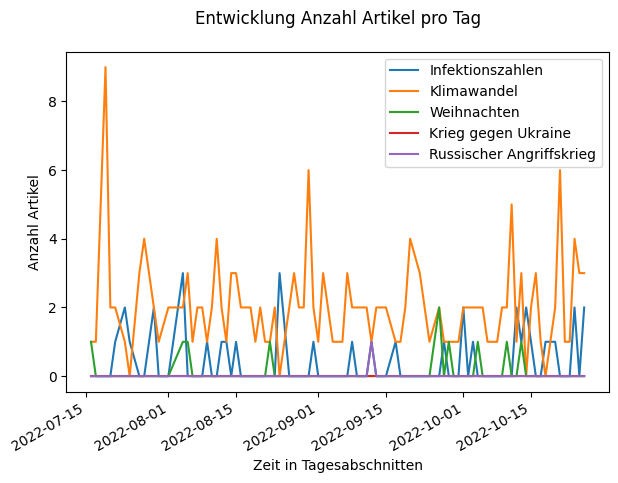

In [14]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_all_day.plot(kind="line", x="date", y=target, ax=ax, xlabel="Zeit in Tagesabschnitten", figsize=(7,5), ylabel="Anzahl Artikel")

ax.set_title(f'Entwicklung Anzahl Artikel pro Tag', pad=20)

fig.savefig(f'figures/bar-keywords-trend-day.png')

## 2. Gruppiere Artikel nach: Woche (eindeutig)

In [15]:
df_all_week = None

def process(row):
    year = row["year"]
    week = row["week"]
    date = "{}-{}-1".format(year, week)
    dt = dt.strptime(date, "%Y-%W-%w")
    return dt.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] + 'Z'

for keyword in keywords:
    # Betrachte nur die Artikel des aktuellen Themengebiets
    df_topic = df.loc[df.keyword == keyword]
    # Gruppiere die Artikel nach Woche (eindeutig) und aggregiere die Anzahl der Artikel pro Woche
    df_weekly_topic = df_topic.groupby(["week", "year"]).size().reset_index(name=keyword)
    
    # Füge ein neues Feature hinzu: Datum
    df_weekly_topic['date'] = df_weekly_topic['week'].astype(str) + " " + df_weekly_topic['year'].astype(str)
    #df_weekly_topic['date'] = pd.to_datetime(df.year.astype(str), format='%Y') + pd.to_timedelta(df.week.mul(7).astype(str) + ' days')
    #df_weekly_topic['date'] = df_weekly_topic.apply(process)
    #df_weekly_topic['date'] = pd.to_datetime((df_weekly_topic.year*100+df_weekly_topic.week).astype(str) + '0', format='%Y%W%w')

    # Lösche zwei Features: Woche, Jahr
    df_weekly_topic.drop(['week', 'year'], axis=1, inplace=True)

    # Falls der df der Gesamtdaten bereits Daten von vorherigen Themengebieten enthält, merge die Daten des aktuellen Themengebiets
    if (isinstance(df_all_week, pd.DataFrame)):
        df_all_week = pd.merge(df_all_week, df_weekly_topic, how='outer', on="date")
    # Initialisiere den df der Gesamtdaten mit den Daten des aktuellen Themengebiets
    else:
        df_all_week = df_weekly_topic

# Fülle die leeren Felder mit der Anzahl 0
df_all_week = df_all_week.fillna(0)

#### Erstelle das Diagramm

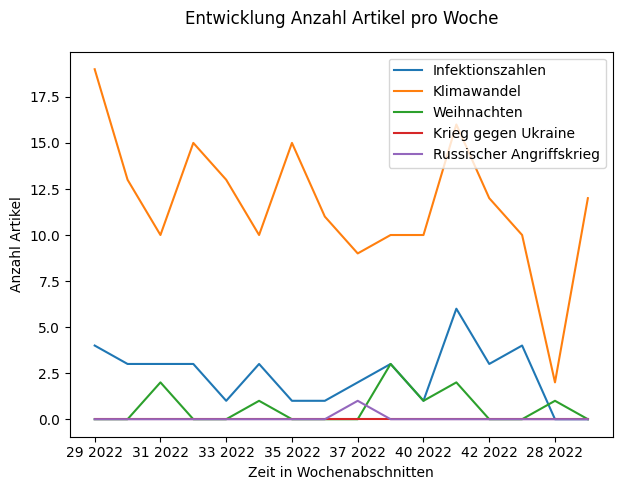

In [16]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_all_week.plot(kind="line", x="date", y=target, ax=ax, xlabel="Zeit in Wochenabschnitten", figsize=(7,5), ylabel="Anzahl Artikel")

ax.set_title(f'Entwicklung Anzahl Artikel pro Woche', pad=20)

fig.savefig(f'figures/bar-keywords-trend-week.png')

## 3. Gruppiere Artikel nach: Monat (eindeutig)

In [17]:
df_all_month = None

for keyword in keywords:
    # Betrachte nur die Artikel des aktuellen Themengebiets
    df_topic = df.loc[df.keyword == keyword]
    # Gruppiere die Artikel nach Woche (eindeutig) und aggregiere die Anzahl der Artikel pro Woche
    df_monthly_topic = df_topic.groupby(["month", "year"]).size().reset_index(name=keyword)
    
    # Füge ein neues Feature hinzu: Datum
    df_monthly_topic['date'] = df_monthly_topic['month'].astype(str) + " " + df_monthly_topic['year'].astype(str)

    # Lösche zwei Features: Woche, Jahr
    df_monthly_topic.drop(['month', 'year'], axis=1, inplace=True)

    # Falls der df der Gesamtdaten bereits Daten von vorherigen Themengebieten enthält, merge die Daten des aktuellen Themengebiets
    if (isinstance(df_all_month, pd.DataFrame)):
        df_all_month = pd.merge(df_all_month, df_monthly_topic, how='outer', on="date")
    # Initialisiere den df der Gesamtdaten mit den Daten des aktuellen Themengebiets
    else:
        df_all_month = df_monthly_topic

# Fülle die leeren Felder mit der Anzahl 0
df_all_month = df_all_month.fillna(0)

#### Erstelle das Diagramm

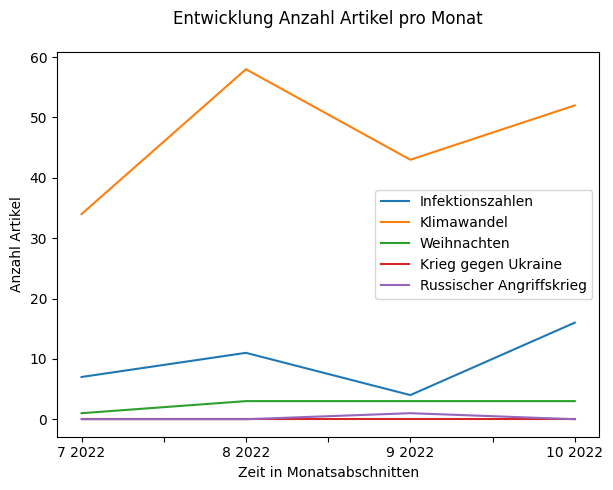

In [18]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_all_month.plot(kind="line", x="date", y=target, ax=ax, xlabel="Zeit in Monatsabschnitten", figsize=(7,5), ylabel="Anzahl Artikel")

ax.set_title(f'Entwicklung Anzahl Artikel pro Monat', pad=20)

fig.savefig(f'figures/bar-keywords-trend-month.png')